# Software Demonstration

*The following interactive notebook is to help demonstrate some of the software capabalities for our project*



### The Log File

Currently we receive the data in a log file that looks like this:

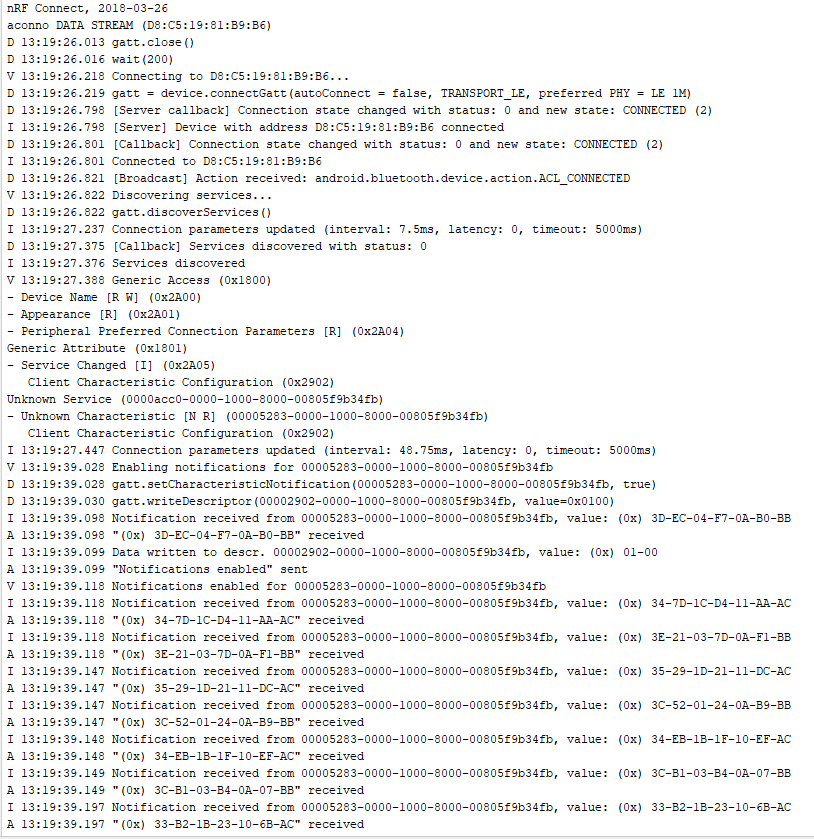

The log file contains a lot information we don't need. The only data we need is the timestamp and the values from the accelerometer,

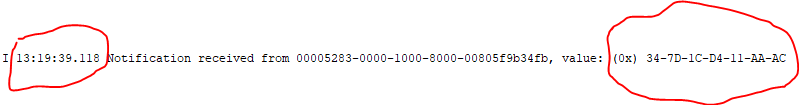

We also needed to be able to determine which board the data was coming from, the aconno board or the breakout board. 

To distinguish between the two, the firmware set the last two digits as either **AC** or **BB**

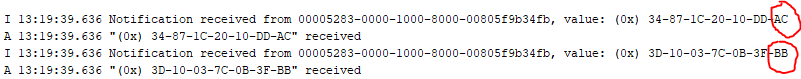

In [1]:
import csv
import math
import sys
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import spline
from datetime import datetime, timedelta
from math import atan
from numpy import arctan


# ---------------------------------------------------------------------
# function to transform hex string like "0xff4c" into signed integer
# ---------------------------------------------------------------------
def hexStrToInt(hexstr):
    val = int(hexstr, 16)           # convert to unsigned
    if ((val & 0x8000) == 0x8000):  # check sign bit
        val = -((val ^ 0xffff) + 1) # if set, inver and add one to get the negative value, then add the negative sign
    return val
# ---------------------------------------------------------------------

# ---------------------------------------------------------------------
# function to plot
# ---------------------------------------------------------------------
def plot_results(times,x_acc,y_acc,z_acc,velocity_x,velocity_y,velocity_z,position_x,position_y,position_z):
    # Check to make sure lengths are equal
    if len(times) != len(x_acc):
        #print("times and acceleration x lengths don't match", '\n', len(times), len(velocity_x), '\n', times,'\n', velocity_x)
        del times[-1]
    else:
        print("times and acceleration x lengths DO match:  ",len(times)," ",len(x_acc))
        # print("Upper Arm time vector length: ",len(times))
        # print(" Acceleration vector length: ",len(x_acc),'\n')

    plt.subplot(3,3,1)
    plt.plot(times, x_acc)
    plt.title("Acceleration")
    plt.ylabel("X")
    plt.ylim(-20,20)

    plt.subplot(3, 3, 4)
    plt.plot(times, y_acc)
    plt.ylabel("Y")
    plt.ylim(-20, 20)

    plt.subplot(3, 3, 7)
    plt.plot(times, z_acc)
    plt.ylabel("Z")
    plt.ylim(-20, 20)
    plt.xlabel("Time")

    # Check to make sure lengths are equal
    if len(times) != len(velocity_x):
        print("times and velocity x lengths don't match: ",len(times),len(velocity_x))
        del times[-1]
        #del times[-1]
    else:
        print("times and velocity x lengths DO match: ",len(times),len(velocity_x))

    plt.subplot(3,3, 2)
    plt.plot(times, velocity_x)
    plt.title("Velocity")

    plt.subplot(3, 3, 5)
    plt.plot(times, velocity_y)
    #plt.title("Y Velocity")

    plt.subplot(3, 3, 8)
    plt.plot(times, velocity_z)
    #plt.title("Z Velocity")
    plt.xlabel("Time")

    # Check to make sure lengths are equal
    if len(times) != len(position_x):
        print("times and velocity x lengths don't match: ",len(times),len(velocity_x))
        del time[-1]
    else:
        print("times and position x lengths DO match: ",len(times),len(velocity_x), '\n')

    plt.subplot(3, 3, 3)
    plt.plot(times, position_x)
    plt.title("Position")

    plt.subplot(3, 3, 6)
    plt.plot(times, position_y)
    #plt.title("Y Position")

    plt.subplot(3, 3, 9)
    plt.plot(times, position_z)
    #plt.title("Z Position")
    plt.xlabel("Time")
    plt.show(block=True)
    return
# ---------------------------------------------------------------------

with open('Log 2018-03-26 13_51_49.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line for line in stripped if line)
    with open('Log 2018-03-26 13_51_49.csv', 'w', newline='') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('Time Stamp','X Acceleration','Y Acceleration','Z Acceleration','X Velocity','Y Velocity','Z Velocity','X Position', 'Y Position', 'Z Position'))

        #Create variables to recognize when notifications are enabled for each acceleration service
        acc_enabled = 0

        #Create empty acceleration lists
        x_acc_UA, y_acc_UA, z_acc_UA = [],[],[];
        x_acc_LA, y_acc_LA, z_acc_LA = [], [], [];

        #Create timestamp for x,y,z
        acc_times_UA, acc_times_LA = [],[];
        g = 9.81
        out_string_x, out_string_y, out_string_z, out_string_source = '','','','';

        for line in lines:
            line = line.strip()

            # Check for receiving values
            if line.find('Notifications enabled for 00005283-0000-1000-8000-00805f9b34fb') != -1:
                acc_enabled = 1

            # Start recording once receiving receiving acceleration values
            if acc_enabled == 1:

                if line.find('received from 00005283') != -1:

                    out_string_x = line[88:90]; out_string_y = line[88:90];out_string_z = line[88:90] #0x

                    out_string_x += line[92:94]
                    out_string_x += line[95:97]

                    out_string_y += line[98:100]
                    out_string_y += line[101:103]

                    out_string_z += line[104:106]
                    out_string_z += line[107:109]

                    data_source = line[110:112] #To identify if coming from the aconno or breakout board

                    if data_source == "AC": #aconno board
                        if acc_times_UA == []:
                            time_start_UA = timedelta(hours=float(line[2:4]), minutes=float(line[5:7]),
                                                      seconds=float(line[8:10]), milliseconds=float(line[11:14]))
                            print("Time Start aconno board: ", time_start_UA)

                        acc_times_UA.append(
                            timedelta(hours=float(line[2:4]), minutes=float(line[5:7]), seconds=float(line[8:10]),
                                        milliseconds=float(line[11:14])))

                        x_acc_UA.append(float(hexStrToInt(out_string_x)) * (0.061 / 1000) * g)
                        y_acc_UA.append(float(hexStrToInt(out_string_y)) * (0.061 / 1000) * g)
                        z_acc_UA.append(float(hexStrToInt(out_string_z)) * (0.061 / 1000) * g)


                    if data_source == "BB": #breakout board
                        if acc_times_LA == []:
                            time_start_LA = timedelta(hours=float(line[2:4]), minutes=float(line[5:7]),
                                                      seconds=float(line[8:10]), milliseconds=float(line[11:14]))
                            print("Time Start breakout board: ", time_start_LA)

                        acc_times_LA.append(
                            timedelta(hours=float(line[2:4]), minutes=float(line[5:7]), seconds=float(line[8:10]),
                                      milliseconds=float(line[11:14])))

                        x_acc_LA.append(float(hexStrToInt(out_string_x)) * (0.061 / 1000) * g)
                        y_acc_LA.append(float(hexStrToInt(out_string_y)) * (0.061 / 1000) * g)
                        z_acc_LA.append(float(hexStrToInt(out_string_z)) * (0.061 / 1000) * g)

                    out_string_x, out_string_y,out_string_z, data_source = '','','','';
                    
        time_end_UA = acc_times_UA[-1]
        time_end_LA = acc_times_LA[-1]
        print("Time End aconno board:   ", time_end_UA)
        print("Time End breakout board:   ", time_end_LA, '\n')

Time Start breakout board:  13:51:35.684000
Time Start aconno board:  13:51:35.684000
Time End aconno board:    13:51:48.560000
Time End breakout board:    13:51:48.560000 



## Using the Data

Now that the file has parsed for the useful information, we can now start to use it


Because of the way the data comes in, we need to check if the data that we parsed above is all equal length in order to integrate later, as well convert the timestamp into something useful

In [ ]:
        # ------------------------------------------------------
        # Convert accelertaion times for graphing
        times_UA, times_LA = [], [];

        for time_UA in acc_times_UA:
            new_time_UA = (time_UA / timedelta(seconds=1)) - (time_start_UA / timedelta(seconds=1))
            times_UA.append(new_time_UA)

        for time_LA in acc_times_LA:
            new_time_LA = (time_LA / timedelta(seconds=1)) - (time_start_LA / timedelta(seconds=1))
            times_LA.append(new_time_LA)  
    
        # ------------------------------------------------------
        # Check to make sure lengths are equal
        if len(x_acc_UA) != len(y_acc_UA) != len(z_acc_UA) != len(times_UA):
            print("Upper Arm acceleration lengths don't match: ", len(times_UA), len(x_acc_UA))
            acc_data_good_UA = 0
        else:
            print("Upper Arm acceleration data is equal length: ", len(times_UA), len(x_acc_UA))
            acc_data_good_UA = 1

        if len(x_acc_LA) != len(y_acc_LA) != len(z_acc_LA) != len(times_LA):
            print("Lower Arm acceleration lengths don't match: ", len(times_LA), len(x_acc_LA), '\n')
            acc_data_good_LA = 0
        else:
            print("Lower Arm acceleration data is equal length: ", len(times_LA), len(x_acc_LA), '\n')
            acc_data_good_LA = 1

Next, we prepare for integration

In [ ]:
        # Create empty acceleration lists
        acceleration_x_UA, acceleration_y_UA, acceleration_z_UA = np.array([]), np.array([]), np.array([]);
        acceleration_x_LA, acceleration_y_LA, acceleration_z_LA = np.array([]), np.array([]), np.array([]);
        velocity_x_UA, velocity_y_UA, velocity_z_UA = [0], [0], [0];
        velocity_x_LA, velocity_y_LA, velocity_z_LA = [0], [0], [0];
        position_x_UA, position_y_UA, position_z_UA = [0], [0], [0];
        position_x_LA, position_y_LA, position_z_LA = [0], [0], [0];

        time_vec_UA, time_vec_LA = np.array(acc_times_UA), np.array(acc_times_LA);
        acceleration_x_UA, acceleration_x_LA = np.array(x_acc_UA), np.array(x_acc_LA);
        acceleration_y_UA, acceleration_y_LA = np.array(y_acc_UA), np.array(y_acc_LA);
        acceleration_z_UA, acceleration_z_LA = np.array(z_acc_UA), np.array(z_acc_LA);

        #
        n_start_UA, n_start_LA = 0, 0;
        n_end_UA, n_end_LA = len(acceleration_z_UA), len(acceleration_z_LA);

        interv_to_int_UA = (np.linspace(n_start_UA, n_end_UA, n_end_UA - n_start_UA + 1, dtype=int))
        interv_to_int_UA = interv_to_int_UA[0:len(interv_to_int_UA) - 2]
        interv_to_int_LA = (np.linspace(n_start_LA, n_end_LA, n_end_LA - n_start_LA + 1, dtype=int))
        interv_to_int_LA = interv_to_int_LA[0:len(interv_to_int_LA) - 2]

        acceleration_x_UA = acceleration_x_UA[interv_to_int_UA] - np.mean(acceleration_x_UA[1:5])
        acceleration_y_UA = acceleration_y_UA[interv_to_int_UA] - np.mean(acceleration_y_UA[1:5])
        acceleration_z_UA = acceleration_z_UA[interv_to_int_UA] - np.mean(acceleration_z_UA[1:5])
        acceleration_x_LA = acceleration_x_LA[interv_to_int_LA] - np.mean(acceleration_x_LA[1:5])
        acceleration_y_LA = acceleration_y_LA[interv_to_int_LA] - np.mean(acceleration_y_LA[1:5])
        acceleration_z_LA = acceleration_z_LA[interv_to_int_LA] - np.mean(acceleration_z_LA[1:5])

        total_seconds_UA = (time_end_UA - time_start_UA) / timedelta(seconds=1)
        total_seconds_LA = (time_end_LA - time_start_LA) / timedelta(seconds=1)
        print("Total seconds aconno board: ", total_seconds_UA)
        print("Total seconds breakout board: ", total_seconds_LA, '\n')

        time_vec_UA = time_vec_UA[interv_to_int_UA]
        time_vec_LA = time_vec_LA[interv_to_int_UA]

        delta_x_UA = np.mean(np.diff(time_vec_UA)) / timedelta(seconds=1)  # mean time between samples
        delta_y_UA = delta_x_UA
        delta_z_UA = delta_x_UA
        delta_x_LA = np.mean(np.diff(time_vec_LA)) / timedelta(seconds=1)  # mean time between samples
        delta_y_LA = delta_x_LA
        delta_z_LA = delta_x_LA

In the above code we,
- Converted the acceleration into an numerical array
- Took the average of the first 5 values and subtracted from all of the acceleration values
- Calculated the total time of the recorded data
- Determined the mean time between samples

### Now we can integrate!

In [ ]:
        # ------------------------------------------------------
        # Integrate Acceleration    
        del times_UA[-1]
        velocity_x_UA = integrate.cumtrapz(acceleration_x_UA,times_UA,delta_x_UA,axis=-1,initial=acceleration_x_UA[1])
        velocity_y_UA = integrate.cumtrapz(acceleration_y_UA,times_UA,delta_y_UA,axis=-1,initial=acceleration_y_UA[1])
        velocity_z_UA = integrate.cumtrapz(acceleration_z_UA,times_UA,delta_z_UA,axis=-1,initial=acceleration_z_UA[1])
        del times_LA[-1]
        velocity_x_LA = integrate.cumtrapz(acceleration_x_LA, times_LA, delta_x_LA, axis=-1,
                                           initial=acceleration_x_LA[1])
        velocity_y_LA = integrate.cumtrapz(acceleration_y_LA, times_LA, delta_y_LA, axis=-1,
                                           initial=acceleration_y_LA[1])
        velocity_z_LA = integrate.cumtrapz(acceleration_z_LA, times_LA, delta_z_LA, axis=-1,
                                           initial=acceleration_z_LA[1])
        print("After accleration integration UA time and vel vector lengths are: ",len(times_UA),len(velocity_x_UA))
        print("After accleration integration LA time and vel vector lengths are: ", len(times_LA), len(velocity_x_LA),'\n')


        # ------------------------------------------------------
        # Integrate Velocity
        position_x_UA = integrate.cumtrapz(velocity_x_UA,times_UA,delta_x_UA,axis=-1,initial=velocity_x_UA[1])
        position_y_UA = integrate.cumtrapz(velocity_y_UA, times_UA, delta_y_UA, axis=-1,
                                           initial=velocity_y_UA[1])
        position_z_UA = integrate.cumtrapz(velocity_z_UA, times_UA, delta_z_UA, axis=-1,
                                           initial=velocity_z_UA[1])

        position_x_LA = integrate.cumtrapz(velocity_x_LA, times_LA, delta_x_LA, axis=-1,
                                           initial=velocity_x_LA[1])
        position_y_LA = integrate.cumtrapz(velocity_y_LA, times_LA, delta_y_LA, axis=-1,
                                           initial=velocity_y_LA[1])
        position_z_LA = integrate.cumtrapz(velocity_z_LA, times_LA, delta_z_LA, axis=-1,
                                           initial=velocity_z_LA[1])


### Now we have all this data! Now what??

First you could put the data into an excel file using the following,

In [ ]:
        # ------------------------------------------------------
        # Write to CSV file
        if acc_data_good_UA == 1:
            for acc_time_UA, x_acc_UA_f, y_acc_UA_f, z_acc_UA_f, velocity_x_UA_f, velocity_y_UA_f, velocity_z_UA_f, position_x_UA_f, position_y_UA_f, position_z_UA_f in zip(
                    acc_times_UA, x_acc_UA, y_acc_UA, z_acc_UA, velocity_x_UA, velocity_y_UA, velocity_z_UA, position_x_UA, position_y_UA, position_z_UA):
                grouped = acc_time_UA/timedelta(seconds=1)-time_start_UA/timedelta(seconds=1), x_acc_UA_f, y_acc_UA_f, z_acc_UA_f, velocity_x_UA_f, velocity_y_UA_f, velocity_z_UA_f, position_x_UA_f, position_y_UA_f, position_z_UA_f
                writer.writerow(grouped)

        writer.writerow(("Breakout Board Data"))
                
        if acc_data_good_LA == 1:
            for acc_time_LA, x_acc_LA_f, y_acc_LA_f, z_acc_LA_f, velocity_x_LA_f, velocity_y_LA_f, velocity_z_LA_f, position_x_LA_f, position_y_LA_f, position_z_LA_f in zip(
                    acc_times_LA, x_acc_LA, y_acc_LA, z_acc_LA, velocity_x_LA, velocity_y_LA, velocity_z_LA, position_x_LA, position_y_LA, position_z_LA):
                grouped = acc_time_LA/timedelta(seconds=1)-time_start_LA/timedelta(seconds=1), x_acc_LA_f, y_acc_LA_f, z_acc_LA_f, velocity_x_LA_f, velocity_y_LA_f, velocity_z_LA_f, position_x_LA_f, position_y_LA_f, position_z_LA_f
                writer.writerow(grouped)

We can also plot the data,

In [ ]:
        #--------------------------------------------------------
        #Plot
        print("Upper Arm ")
        plot_results(times_UA,x_acc_UA,y_acc_UA,z_acc_UA,velocity_x_UA,velocity_y_UA,velocity_z_UA,position_x_UA,position_y_UA,position_z_UA)
        print("Lower Arm ")
        plot_results(times_LA,x_acc_LA,y_acc_LA,z_acc_LA,velocity_x_LA,velocity_y_LA,velocity_z_LA,position_x_LA,position_y_LA,position_z_LA)

Starting from a simple test such as raising one's arm, we get the following plots,

### The aconno board

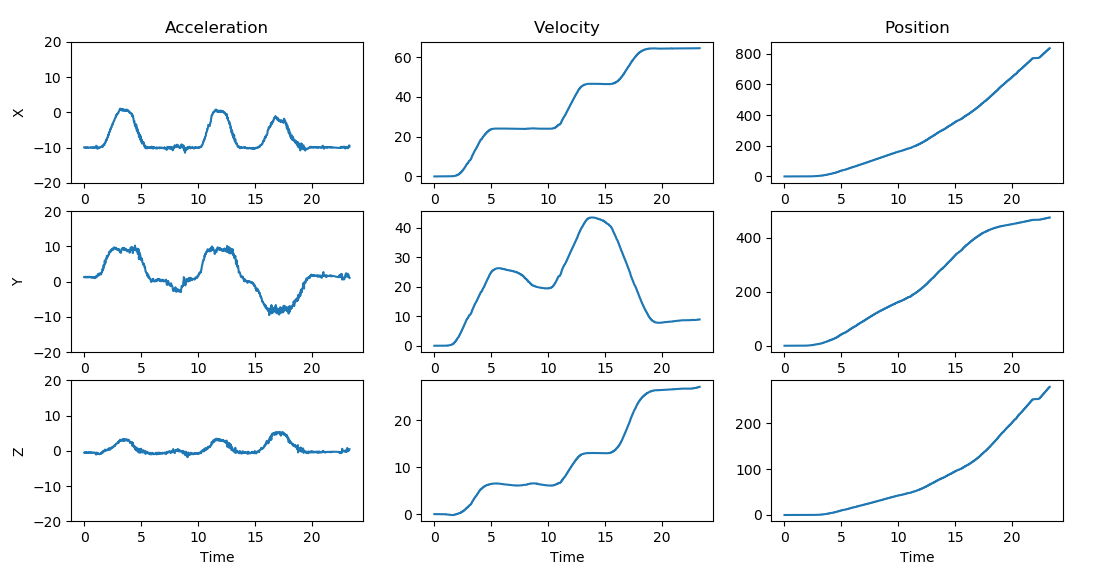

### The breakout board

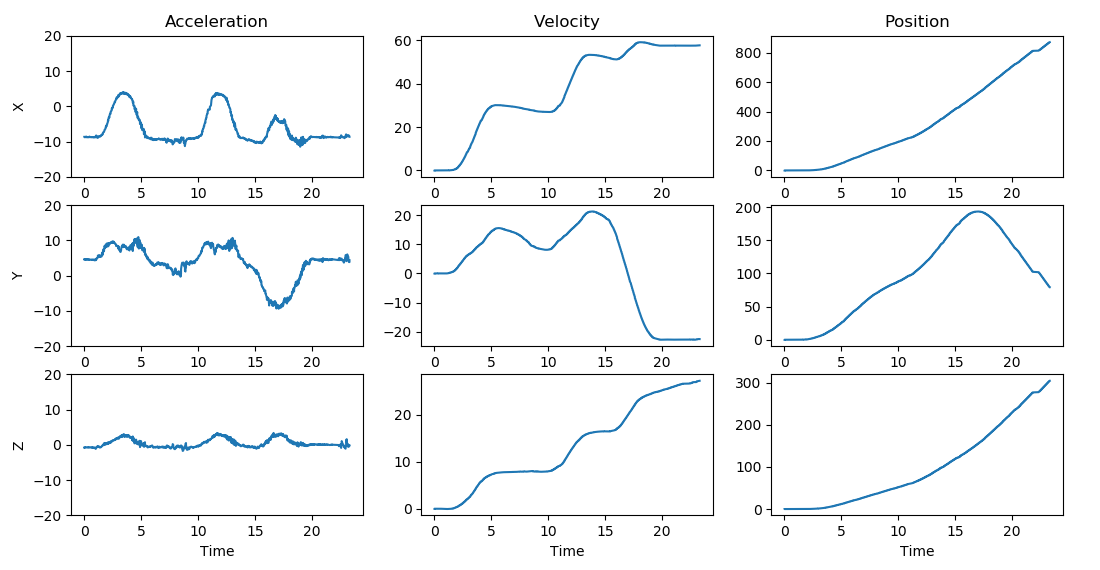



### Does this data make sense?

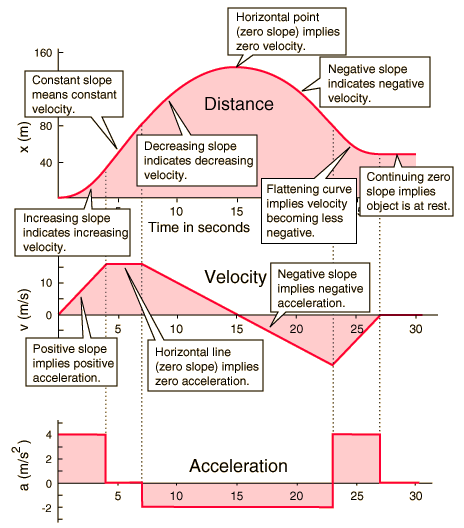





The following graphs are from our testing of a simple arm swing performed three times,

### The aconno board

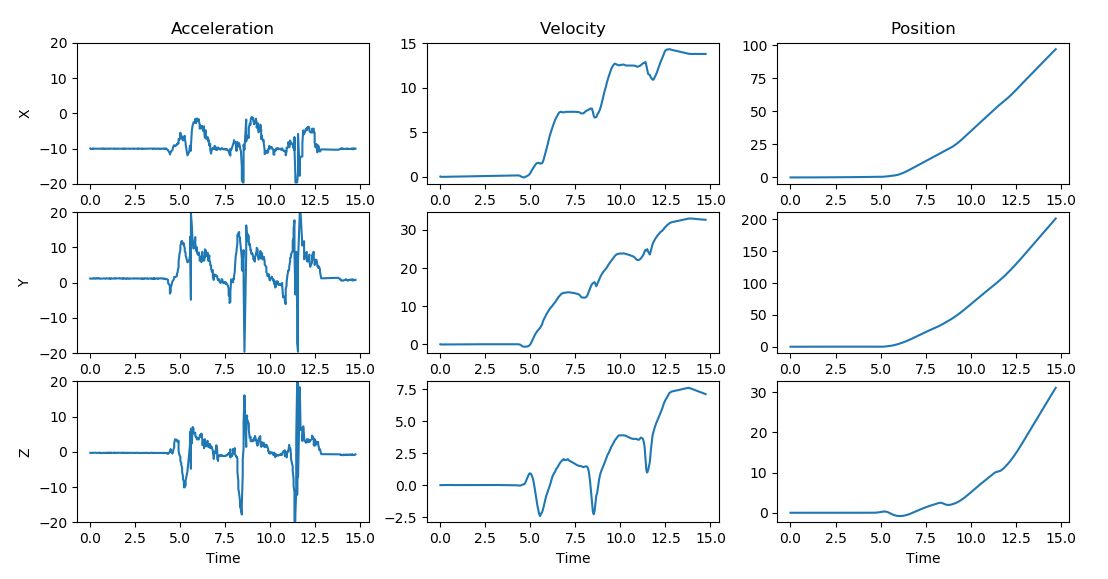


### The breakout board

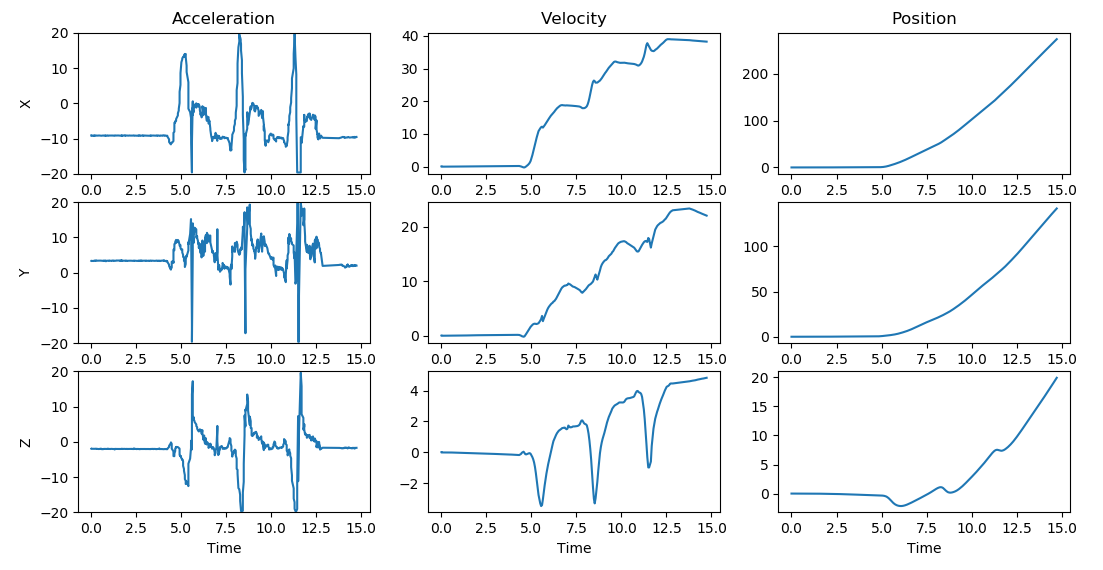





The next test was a special arm movement to isolate different axises,

### The aconno board

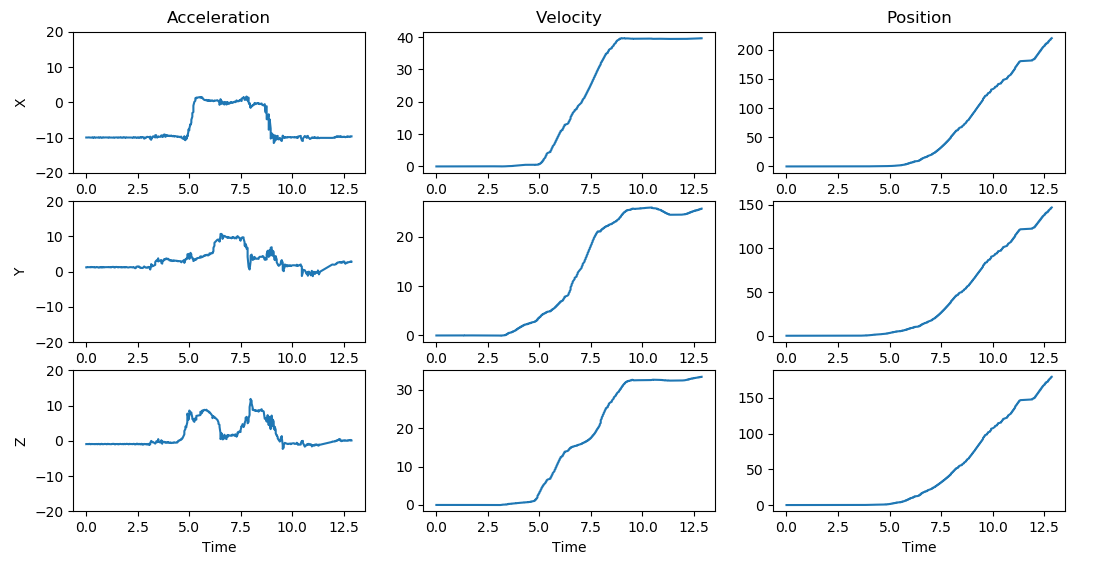

### The breakout board

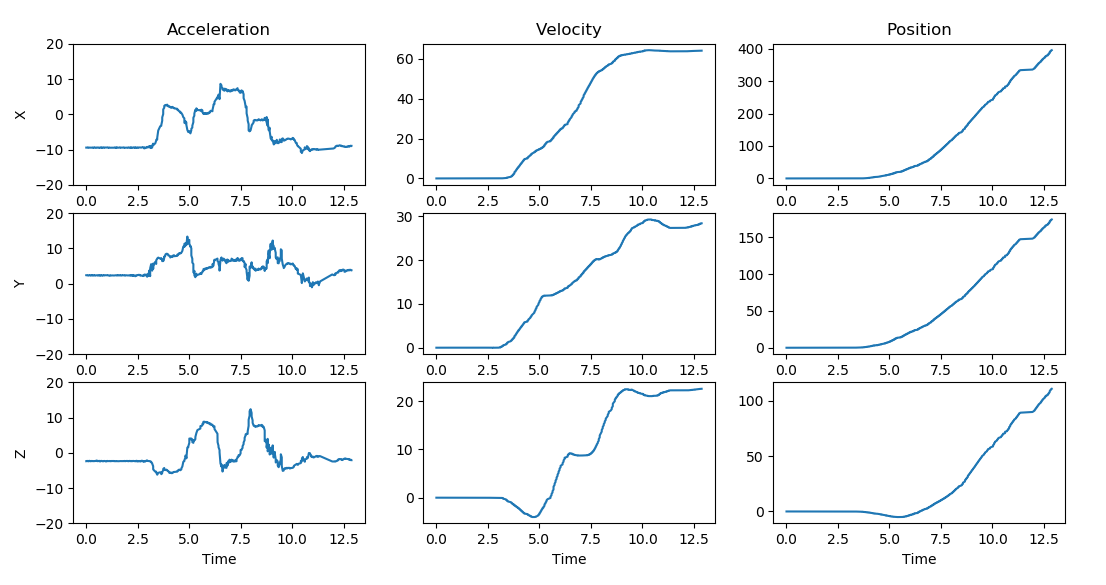



We also compared the overall magnitudes using the following code:

In [ ]:
# ---------------------------------------------------------------------
# function to calculate acceleration, velocity, and positions total magnitudes
# ---------------------------------------------------------------------
def calcMagnitudes(x_acc, y_acc, z_acc, velocity_x, velocity_y, velocity_z, position_x, position_y, position_z):
    Mag_acc, Mag_vel, Mag_pos = [], [], [];

    for x_acc_f, y_acc_f, z_acc_f in zip(x_acc, y_acc, z_acc):
        Mag_acc.append((x_acc_f ** 2 + y_acc_f ** 2 + z_acc_f ** 2) ** (1.0 / 2.0))
    for velocity_x_f, velocity_y_f, velocity_z_f in zip(velocity_x, velocity_y, velocity_z):
        Mag_vel.append((velocity_x_f ** 2 + velocity_y_f ** 2 + velocity_z_f ** 2) ** (1.0 / 2.0))
    for position_x_f, position_y_f, position_z_f in zip(position_x, position_y, position_z):
        Mag_pos.append((position_x_f ** 2 + position_y_f ** 2 + position_z_f ** 2) ** (1.0 / 2.0))

    return Mag_acc, Mag_vel, Mag_vel

        # ------------------------------------------------------
        #Calculate Magnitudes
        Mag_acc_UA, Mag_vel_UA, Mag_pos_UA = calcMagnitudes(x_acc_UA, y_acc_UA, z_acc_UA, velocity_x_UA, velocity_y_UA, velocity_z_UA, position_x_UA, position_y_UA, position_z_UA)
        Mag_acc_LA, Mag_vel_LA, Mag_pos_LA = calcMagnitudes(x_acc_LA, y_acc_LA, z_acc_LA, velocity_x_LA, velocity_y_LA, velocity_z_LA, position_x_LA, position_y_LA, position_z_LA)


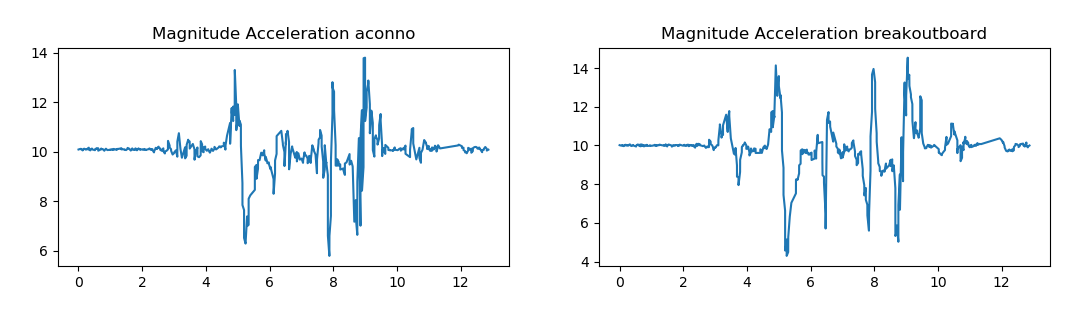